In [3]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

In [13]:
data = pd.read_csv('weather_image_recognition/file_path.csv', index_col='image_id')
data.head()

file_path
image_id                                                   
0000000_  C:\Users\Asus\Desktop\Project\ImageRecommender...
0000001_  C:\Users\Asus\Desktop\Project\ImageRecommender...
0000002_  C:\Users\Asus\Desktop\Project\ImageRecommender...
0000003_  C:\Users\Asus\Desktop\Project\ImageRecommender...
0000004_  C:\Users\Asus\Desktop\Project\ImageRecommender...

In [15]:
len(data)

31932

### MobileNet

In [5]:
import numpy as np
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False)

x = base_model.output
embeddings = layers.GlobalAveragePooling2D()(x) # layer before output

model = Model(base_model.input, embeddings)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, None, None, 512)  4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_pw_9 (Conv2D)          (None, None, None, 512)   262144    
                                                                 
 conv_pw_9

## strategy for include batch size during training

In [7]:
os.getcwd()

'C:\\Users\\Asus\\Desktop\\Project\\ImageRecommender'

In [12]:
def index_generator(dataframe, batch_size=100):
    total_rows = len(dataframe)
    current_index = 0

    while current_index < total_rows:
        end_index = min(current_index + batch_size, total_rows) # so that the last gen can be included
        yield dataframe.index[current_index:end_index]
        current_index += batch_size

In [17]:
# load the generator to load every batch of images
batch_gen = index_generator(data)

# Initialize a list to store the embeddings
embeddings = []

# Process images in batches
for batch in tqdm_notebook(batch_gen, desc='get embeddings', total=len(data)/100):
    image_ids = batch.tolist()
    batch_images = []

    # Process images in the current batch
    for image_id in image_ids:
        image_path = data.loc[image_id].file_path

        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        batch_images.append(x)

    # Concatenate images in the batch
    batch_images = np.concatenate(batch_images, axis=0)

    # Extract the embeddings for the batch
    batch_embeddings = model.predict(batch_images)
    batch_embeddings = batch_embeddings.reshape(batch_embeddings.shape[0], -1)

    # Append the embeddings to the list
    embeddings.append(batch_embeddings)

# Concatenate embeddings from all batches
embeddings = np.concatenate(embeddings, axis=0)

# Print the shape of the embeddings array
print(embeddings.shape)

get embeddings:   0%|          | 0/319.32 [00:00<?, ?it/s]

4/4 [==============================] - 2s 408ms/step


4/4 [==============================] - 2s 420ms/step


1/1 [==============================] - 1s 584ms/step
(31932, 1024)


In [18]:
embeddings.min(), embeddings.max()

(0.0, 6.0)

In [19]:
embeddings.shape

(31932, 1024)

In [13]:
os.getcwd()

'C:\\Users\\Asus\\Desktop\\Project\\ImageRecommender'

In [26]:
embeddings = np.array(embeddings)
df = pd.DataFrame(embeddings)
df['id'] = data.index 
df = df.set_index('id')
df.head()

0         1         2         3         4         5     \
id                                                                     
0000000_  1.702602  0.280345  0.002875  0.392063  0.058732  0.072598   
0000001_  1.082599  0.056388  0.000000  0.305775  0.001646  0.084357   
0000002_  2.344831  0.095258  0.929714  0.007168  0.393723  0.000000   
0000003_  1.923374  0.469801  0.000000  0.000000  0.034059  0.032183   
0000004_  1.212457  0.000000  0.730530  0.260026  0.692328  1.183607   

              6         7         8         9     ...      1014      1015  \
id                                                ...                       
0000000_  0.823098  0.085063  0.271215  0.000000  ...  0.001516  0.000000   
0000001_  0.024238  0.000000  0.245861  2.627593  ...  1.636400  0.074678   
0000002_  1.015506  0.055767  1.104065  0.234005  ...  0.115671  0.005713   
0000003_  0.000000  0.208176  2.159894  0.041754  ...  2.693473  0.074690   
0000004_  0.000000  0.000000  0.023676  1.795062  ...  1.602074  0.009075   

              1016      1017      1018      1019      1020      1021  \
id                                                                     
0000000_  0.916635  0.434451  0.000000  2.207779  0.078891  0.004087   
0000001_  0.247777  0.000000  0.092174  0.165596  6.000000  1.257296   
0000002_  1.477797  1.545036  0.764558  0.961210  0.254579  0.242481   
0000003_  0.710116  0.019694  0.221126  0.000000  5.245052  0.109389   
0000004_  0.021297  0.241891  0.560821  1.275403  0.321218  0.000000   

              1022      1023  
id                            
0000000_  0.022139  0.790070  
0000001_  0.000000  0.559314  
0000002_  0.213318  0.218131  
0000003_  0.000000  0.000000  
0000004_  0.000000  1.439156  

[5 rows x 1024 columns]

In [23]:
df.shape 

(31932, 1024)

In [24]:
df.head()

0         1         2         3         4         5         6     \
0  1.702602  0.280345  0.002875  0.392063  0.058732  0.072598  0.823098   
1  1.082599  0.056388  0.000000  0.305775  0.001646  0.084357  0.024238   
2  2.344831  0.095258  0.929714  0.007168  0.393723  0.000000  1.015506   
3  1.923374  0.469801  0.000000  0.000000  0.034059  0.032183  0.000000   
4  1.212457  0.000000  0.730530  0.260026  0.692328  1.183607  0.000000   

       7         8         9     ...      1014      1015      1016      1017  \
0  0.085063  0.271215  0.000000  ...  0.001516  0.000000  0.916635  0.434451   
1  0.000000  0.245861  2.627593  ...  1.636400  0.074678  0.247777  0.000000   
2  0.055767  1.104065  0.234005  ...  0.115671  0.005713  1.477797  1.545036   
3  0.208176  2.159894  0.041754  ...  2.693473  0.074690  0.710116  0.019694   
4  0.000000  0.023676  1.795062  ...  1.602074  0.009075  0.021297  0.241891   

       1018      1019      1020      1021      1022      1023  
0  0.000000  2.207779  0.078891  0.004087  0.022139  0.790070  
1  0.092174  0.165596  6.000000  1.257296  0.000000  0.559314  
2  0.764558  0.961210  0.254579  0.242481  0.213318  0.218131  
3  0.221126  0.000000  5.245052  0.109389  0.000000  0.000000  
4  0.560821  1.275403  0.321218  0.000000  0.000000  1.439156  

[5 rows x 1024 columns]

In [ ]:
df.to_csv('weather_image_recognition/embeddings.csv')

## measure similarity

In [4]:
os.getcwd()

'C:\\Users\\Asus\\Desktop\\Project\\ImageRecommender'

In [5]:
df = pd.read_csv('weather_image_recognition/embeddings.csv', index_col='id')
df.head()

0         1         2         3         4         5  \
id                                                                     
0000000_  6.862374  0.699451  0.427140  0.006834  0.104121  0.309327   
0000001_  0.244853  2.544216  0.000000  0.298929  1.176665  0.056427   
0000002_  5.671950  0.085187  0.852656  0.327039  0.000000  0.000000   
0000003_  2.670874  0.000000  0.000000  0.000000  0.000000  0.000000   
0000004_  4.802979  0.000000  0.764017  0.162811  0.000000  0.000000   

                 6         7         8         9  ...      2038      2039  \
id                                                ...                       
0000000_  0.075689  0.686164  0.036264  0.000000  ...  0.058936  0.000000   
0000001_  0.006840  0.000000  0.000000  1.546012  ...  0.118142  0.429420   
0000002_  0.000580  0.000000  0.371360  0.000000  ...  0.000000  0.002479   
0000003_  0.062148  0.000000  0.010454  0.371723  ...  0.000000  0.068883   
0000004_  0.030078  0.005119  0.000000  0.004073  ...  0.014523  0.000000   

              2040      2041      2042      2043      2044      2045  \
id                                                                     
0000000_  0.979317  0.000000  0.029853  0.018639  0.030241  0.232394   
0000001_  0.552497  0.000000  0.000000  0.012463  0.000000  0.000000   
0000002_  0.000000  0.132498  0.251379  0.000000  0.295880  0.098552   
0000003_  0.213882  0.000000  0.000000  0.000000  0.000000  0.007898   
0000004_  0.017444  0.041316  0.000000  0.028519  0.059754  2.096421   

              2046      2047  
id                            
0000000_  0.310612  1.470915  
0000001_  0.127913  0.368000  
0000002_  0.108324  1.189066  
0000003_  0.005712  0.000000  
0000004_  0.039790  1.758875  

[5 rows x 2048 columns]

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

arr_euc = np.array([])
for i in range(len(df)):
    v1 = np.array(df.iloc[7164, :])
    v2 = np.array(df.iloc[i, :])
    arr_euc = np.append(arr_euc, distance.euclidean(v1, v2))

sorted_indices_euc = np.argsort(arr_euc)
print(sorted_indices_euc[:6])

[ 7164 14895 14000 29040  9944 22049]


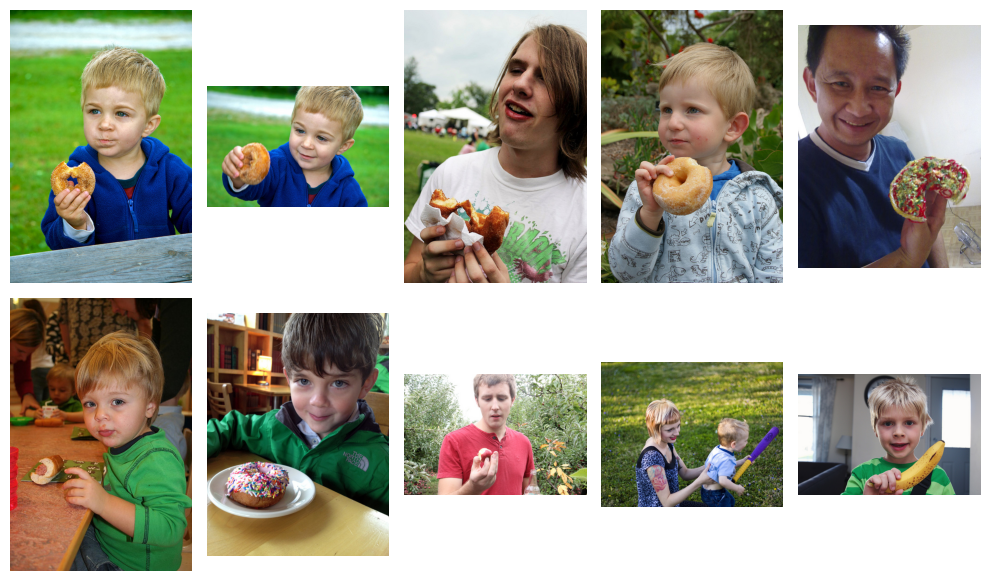

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

top_5_euc = sorted_indices_euc[:10]
#bottom_5_cos = sorted_indices_cos[-10:]
def plot_images(file_paths):
    num_images = len(file_paths)
    num_rows = 2
    num_cols = (num_images + 1) // 2  # Calculate the number of columns based on the number of images

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            try:
                img = mpimg.imread(file_paths[i])
                ax.imshow(img)
                ax.axis('off')
            except IOError:
                print(f"Unable to open image file: {file_paths[i]}")
        else:
            ax.axis('off')  # Hide unused subplot

    plt.tight_layout()
    plt.show()

# Usage example
file_paths = []
for i in top_5_euc:
#for i in bottom_5_cos:
    idx = f"{i:07}_"
    img_path = data.loc[idx]["file_path"]
    file_paths.append(img_path)
    
#file_paths = sorted_indices_euc
plot_images(file_paths)

#### conclusion:
mobilenet perform better than resnet

In [25]:
data['class_'] = data['file_path'].str.split('\\').str[-2]

In [28]:
list(set(data.class_))

['dew',
 'rime',
 'sandstorm',
 'frost',
 'rain',
 'lightning',
 'glaze',
 'snow',
 'unlabeled2017',
 'rainbow',
 'hail',
 'fogsmog']

In [29]:
# convert class name to number for tsne plot
class_mapping = dict()
counter = 0
for item in list(set(data.class_)):
    class_mapping[item] = counter
    counter += 1

class_mapping

{'dew': 0,
 'rime': 1,
 'sandstorm': 2,
 'frost': 3,
 'rain': 4,
 'lightning': 5,
 'glaze': 6,
 'snow': 7,
 'unlabeled2017': 8,
 'rainbow': 9,
 'hail': 10,
 'fogsmog': 11}

In [30]:
data['class_num'] = data['class_'].map(class_mapping)

In [31]:
data.head()

0             1             2         3         4  \
image_id                                                                 
000000_   1.000000e+00  8.741844e-02  7.034527e-01  0.011057  0.052840   
000001_  -1.455192e-11 -1.637090e-11 -1.045919e-11  0.002393  0.005573   
000002_   1.448514e-01  6.331907e-04  1.521892e-02  0.830019  0.188652   
000003_   0.000000e+00  6.572029e-05  0.000000e+00  0.004035  0.008215   
000004_   1.967518e-03  0.000000e+00  0.000000e+00  0.002468  0.000000   

                 5         6         7         8         9  ...            83  \
image_id                                                    ...                 
000000_   0.601915  0.003207  0.083466  0.649100  0.002313  ... -1.437002e-10   
000001_   0.001429  0.007051  0.017359  0.005110  0.021533  ...  4.125379e-01   
000002_   0.400394  1.000000  0.317324  1.000000  0.488636  ...  1.830213e-04   
000003_   0.003885  0.026543  0.050210  0.028661  0.162033  ...  4.267244e-03   
000004_   0.000074  0.002504  0.000000  0.000628  0.007691  ...  1.403405e-03   

                84            85        86        87        88        89  \
image_id                                                                   
000000_   0.000104  5.275069e-11  0.001708  0.001584  0.028443  0.021604   
000001_   0.542714  8.710924e-01  0.555396  1.000000  1.000000  1.000000   
000002_   0.000039  3.637979e-12  0.000070  0.000039  0.000134  0.000000   
000003_   0.002207  1.182965e-03  0.001465  0.001135  0.000000  0.000764   
000004_   0.003470  4.596427e-03  0.001108  0.000000  0.002347  0.000222   

                                                  file_path  class_  class_num  
image_id                                                                        
000000_   C:\Users\Asus\Desktop\Project\ImageRecommender...     dew          0  
000001_   C:\Users\Asus\Desktop\Project\ImageRecommender...     dew          0  
000002_   C:\Users\Asus\Desktop\Project\ImageRecommender...     dew          0  
000003_   C:\Users\Asus\Desktop\Project\ImageRecommender...     dew          0  
000004_   C:\Users\Asus\Desktop\Project\ImageRecommender...     dew          0  

[5 rows x 93 columns]

In [14]:
from sklearn.manifold import TSNE
# Apply t-SNE to the dataset
tsne = TSNE(n_components=2, init="pca",
            perplexity=30,
            random_state=42)
X_tsne = tsne.fit_transform(df)

In [21]:
# Create a DataFrame from the t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

# Save t-SNE results to a CSV file
df_tsne.to_csv('tsne_results.csv', index=False)

array([[ 11.407066, -69.76429 ],
       [ 25.54533 , -35.52865 ],
       [ 16.684835, -66.076324],
       ...,
       [ -9.826782,  38.470776],
       [-68.116295, -29.887346],
       [-38.868748,  10.91163 ]], dtype=float32)

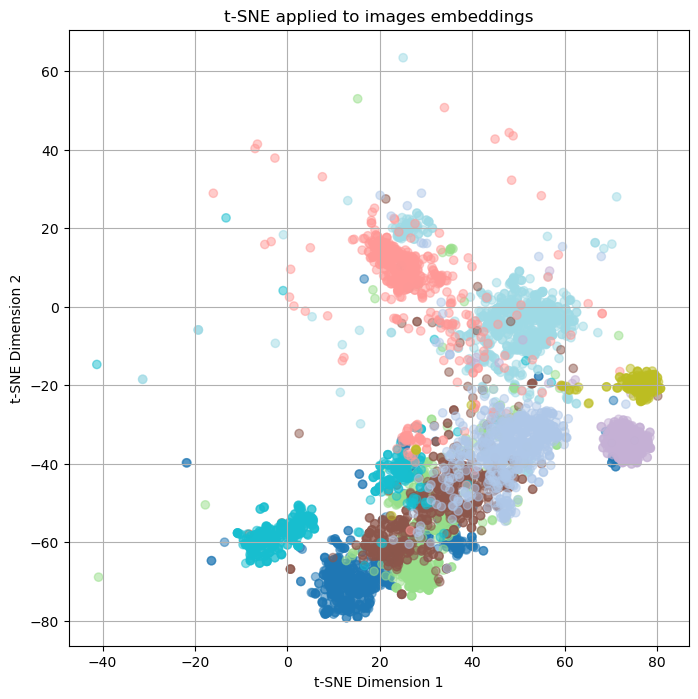

In [34]:
# Visualize the t-SNE results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_tsne[:5000, 0], X_tsne[:5000, 1],
           c=data.class_num.values[:5000], #loss last 32 images
           cmap='tab20', alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE applied to images embeddings")
plt.grid(True)
plt.show()

In [35]:
import plotly.express as px

fig = px.scatter(
    X_tsne, x=0, y=1,
    color=data.class_[:31900], labels={'color': 'class_'},
    opacity=0.5
)
fig.show()